# Necessary Libraries 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import spacy

# spaCy model
nlp = spacy.load("en_core_web_sm")

# Text processing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# File handling
import pickle
import PyPDF2
from docx import Document

# NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
np.random.seed(42)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...


# Data Initially Cleaning 

In [ ]:
df = pd.read_csv('data/UpdatedResumeDataSet.csv')
print(df.columns)
print(df['Category'].value_counts())

df.shape
df.isnull().sum()


Index(['Category', 'Resume'], dtype='object')
Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Sales                        40
Data Science                 40
Mechanical Engineer          40
ETL Developer                40
Blockchain                   40
Operations Manager           40
Arts                         36
Database                     33
Health and fitness           30
PMO                          30
Electrical Engineering       30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
Civil Engineer               24
SAP Developer                24
Advocate                     20
Name: count, dtype: int64


Category    0
Resume      0
dtype: int64

In [19]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

# Data Preprocessing and Feature Engineering

In [66]:
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import spacy
import nltk

# NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

# Defining some SKILL keywords 
SKILL_KEYWORDS = [
    "python", "java", "sql", "machine learning", "deep learning", "nlp",
    "excel", "power bi", "tableau", "c++", "react", "django", "flask"
]
EDUCATION_KEYWORDS = ["bachelor", "master", "phd", "degree", "university", "college"]
EXPERIENCE_KEYWORDS = ["experience", "internship", "project", "worked", "developed", "managed"]

def clean_resume_text(text):
    """
    Clean and preprocess resume text with extra feature engineering:
    - Basic cleaning
    - Lemmatization
    - Extract n-grams
    - Extract keywords (skills, education, experience)
    """
    if not isinstance(text, str):
        return {"cleaned_text": "", "ngrams": [], "skills": [], "education": [], "experience": []}
    
    
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove special chars & digits
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords & lemmatize
    tokens = [
        lemmatizer.lemmatize(word) 
        for word in tokens 
        if word not in stop_words and len(word) > 2
    ]
    
    cleaned_text = " ".join(tokens)
    
    # N grams
    bigrams = list(ngrams(tokens, 2))
    trigrams = list(ngrams(tokens, 3))
    ngram_phrases = [" ".join(gram) for gram in bigrams + trigrams]
    
    # Keyword Extraction 
    skills = [kw for kw in SKILL_KEYWORDS if kw in cleaned_text]
    education = [kw for kw in EDUCATION_KEYWORDS if kw in cleaned_text]
    experience = [kw for kw in EXPERIENCE_KEYWORDS if kw in cleaned_text]
    
    return {
        "cleaned_text": cleaned_text,
        "ngrams": ngram_phrases,
        "skills": skills,
        "education": education,
        "experience": experience
    }

#  Example Run
df = pd.read_csv('data/UpdatedResumeDataSet.csv')

# Apply cleaning
processed_resumes = df['Resume'].apply(clean_resume_text)

df['cleaned_resume'] = processed_resumes.apply(lambda x: x["cleaned_text"])
df['ngrams'] = processed_resumes.apply(lambda x: x["ngrams"])
df['skills'] = processed_resumes.apply(lambda x: x["skills"])
df['experience'] = processed_resumes.apply(lambda x: x["experience"])

print("Sample Resume Keywords Extracted:")
print("Skills:", df['skills'].iloc[0])
print("Experience:", df['experience'].iloc[0])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Sample Resume Keywords Extracted:
Skills: ['python', 'java', 'sql', 'machine learning', 'deep learning', 'tableau', 'flask']
Experience: ['project', 'worked', 'developed']


# Feature Enginnering with TF/IDF

In [68]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Initializing TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,       # top 5000 features
    ngram_range=(1, 2),      # unigrams + bigrams
    stop_words='english'     # remove common stopwords
)

# Fit and transform the cleaned resume text
X = tfidf.fit_transform(df['cleaned_resume']).toarray()


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Category'])

# Check the shape of feature matrix & target
print("Feature matrix shape:", X.shape)   
print("Target variable shape:", y.shape)  

# Save the label encoder for later use 
with open('models/label_encoder.pkl', 'wb') as f:   # saving inside the models
      pickle.dump(label_encoder, f)

# Save the TF-IDF vectorizer as well
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)


Feature matrix shape: (962, 5000)
Target variable shape: (962,)


# Model Training and Evaluation

Training set size: 769
Testing set size: 193

Training Logistic Regression...
Logistic Regression Accuracy: 0.9948

Classification Report for Logistic Regression:
                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         4
                     Arts       1.00      1.00      1.00         7
       Automation Testing       0.83      1.00      0.91         5
               Blockchain       1.00      1.00      1.00         8
         Business Analyst       1.00      1.00      1.00         6
           Civil Engineer       1.00      1.00      1.00         5
             Data Science       1.00      1.00      1.00         8
                 Database       1.00      1.00      1.00         7
          DevOps Engineer       1.00      0.91      0.95        11
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         8
   Electrical Engineering       

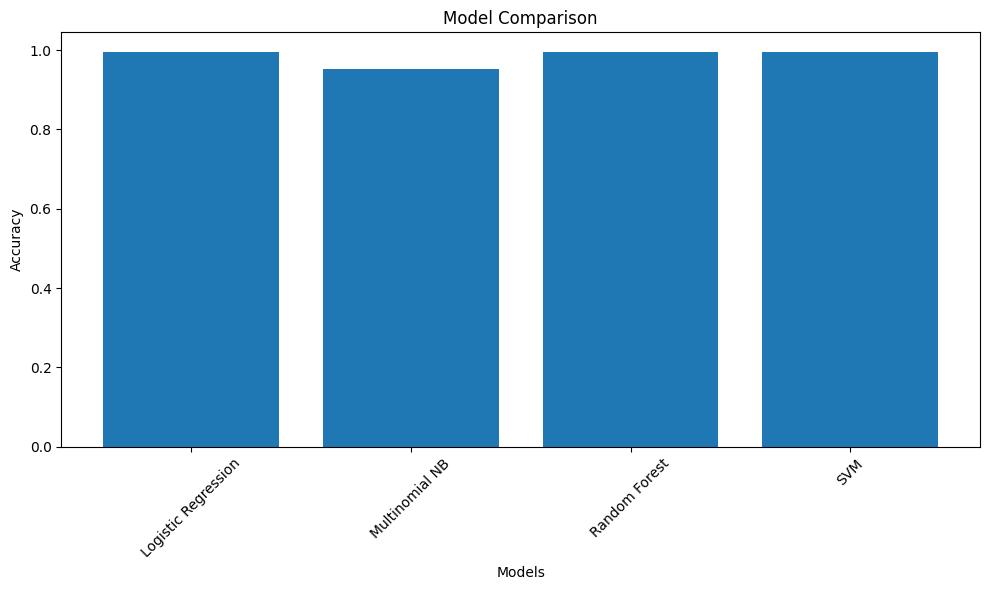

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import pickle
import os

# Spliting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Initializing models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Multinomial NB': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")
    
    # Detailed classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Compare model performance
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.title('Model Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pick model (Logistic Regression )
best_model = LogisticRegression(max_iter=1000, random_state=42)
best_model.fit(X_train, y_train)

# Ensure models folder exists
os.makedirs("models", exist_ok=True)

# Save the model
with open('models/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
    
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)


# For PDF, csv, docx

In [65]:
import os
import pandas as pd
from docx import Document
import PyPDF2
import numpy as np

def extract_text_from_pdf(pdf_file):
    """Extract text from a PDF file"""
    pdf_reader = PyPDF2.PdfReader(pdf_file)
    text = ""
    for page in pdf_reader.pages:
        text += page.extract_text()
    return text

def extract_text_from_docx(docx_file):
    """Extract text from a DOCX file"""
    doc = Document(docx_file)
    text = ""
    for paragraph in doc.paragraphs:
        text += paragraph.text + "\n"
    return text

def predict_resume_category(resume_text, model, vectorizer, label_encoder):
    """Predict job category from resume text"""
    # Clean
    cleaned_text = clean_resume_text(resume_text)["cleaned_text"]  
    text_vectorized = vectorizer.transform([cleaned_text])


    # Predict
    prediction = model.predict(text_vectorized)
    probability = model.predict_proba(text_vectorized)

    # Decode
    category = label_encoder.inverse_transform(prediction)[0]
    confidence = np.max(probability)

    return category, confidence


def predict_from_file(file_path, model, vectorizer, label_encoder):
    """
    Predict job categories from different file types:
    - PDF → single resume
    - DOCX → single resume
    - CSV → batch resumes with 'Resume' column
    - TXT → single text file
    """
    ext = os.path.splitext(file_path)[-1].lower()

    if ext == ".pdf":
        text = extract_text_from_pdf(file_path)
        return [predict_resume_category(text, model, vectorizer, label_encoder)]

    elif ext == ".docx":
        text = extract_text_from_docx(file_path)
        return [predict_resume_category(text, model, vectorizer, label_encoder)]

    elif ext == ".csv":
        df = pd.read_csv(file_path)
        results = []
        for resume_text in df['Resume']:
            results.append(predict_resume_category(resume_text, model, vectorizer, label_encoder))
        return results

    elif ext == ".txt":
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()
        return [predict_resume_category(text, model, vectorizer, label_encoder)]

    else:
        raise ValueError("Unsupported file type. Use PDF, DOCX, CSV, or TXT")


In [55]:
def predict_resume_category(resume_text, model, vectorizer, label_encoder, top_n=3):
    cleaned_text = clean_resume_text(resume_text)["cleaned_text"]
    text_vectorized = vectorizer.transform([cleaned_text])

    probs = model.predict_proba(text_vectorized)[0]
    top_indices = probs.argsort()[::-1][:top_n]

    results = [(label_encoder.inverse_transform([i])[0], float(probs[i])) for i in top_indices]
    return results



In [56]:
# Example: PDF Resume
results = predict_from_file("Resume.pdf", best_model, tfidf, label_encoder)
print(results)



[[('Data Science', 0.2198565127585794), ('Python Developer', 0.08602120154082916), ('Hadoop', 0.054934203082656584)]]


# Evaluation Metrics

Accuracy: 0.9948

Classification Report:
                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         4
                     Arts       1.00      1.00      1.00         7
       Automation Testing       0.83      1.00      0.91         5
               Blockchain       1.00      1.00      1.00         8
         Business Analyst       1.00      1.00      1.00         6
           Civil Engineer       1.00      1.00      1.00         5
             Data Science       1.00      1.00      1.00         8
                 Database       1.00      1.00      1.00         7
          DevOps Engineer       1.00      0.91      0.95        11
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         8
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       1.00      1.00      1.00         9
                   H

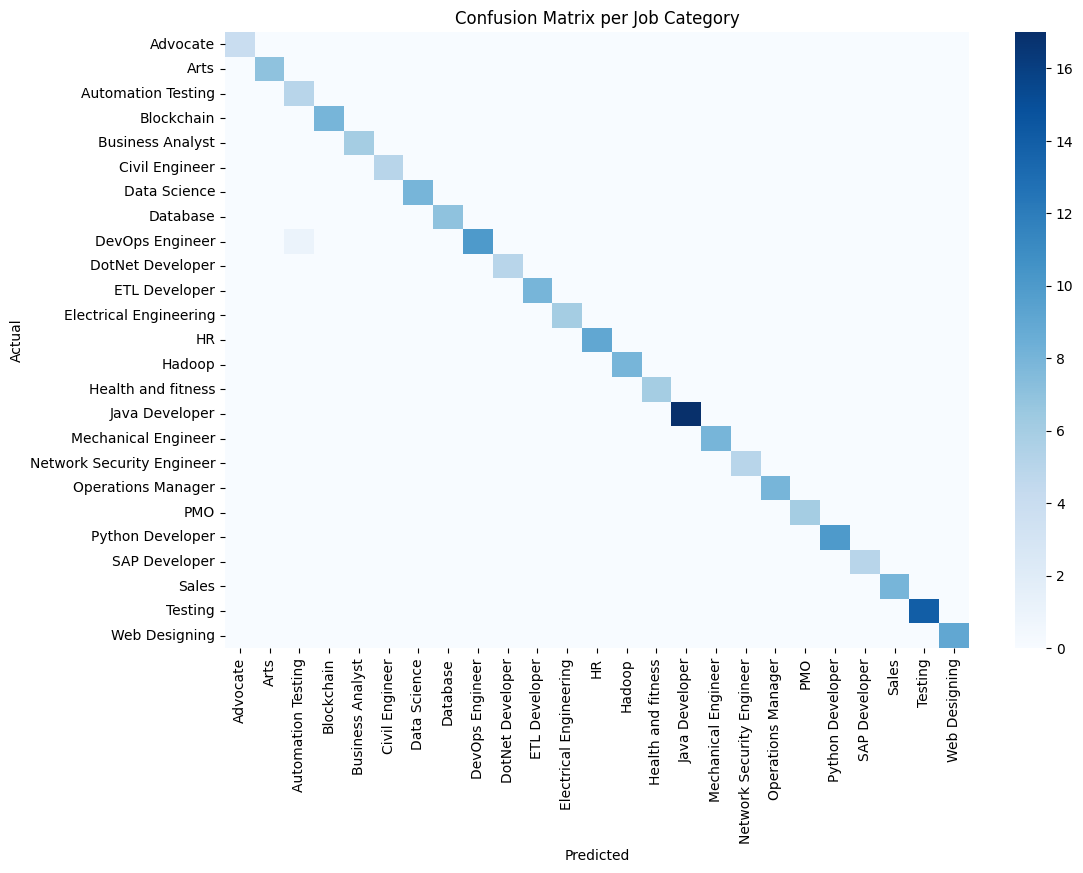

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation 
def evaluate_model(model, X_test, y_test, label_encoder):
    """
    Evaluate model performance with multiple metrics.
    """
    # Predictions
    y_pred = model.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Precision, Recall, F1
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix per Job Category")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


# Run Evaluation 
evaluate_model(best_model, X_test, y_test, label_encoder)
